In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=dc9529d8a0faa215498ba48e7925d14183627ac48a887494af3df4c82f3aae70
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Install the kaggle library using pip
! pip install kaggle

# Create a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
%pylab inline
import plotly.express as px
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import regexp_replace, col
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from datetime import datetime, date
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,\
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Download the Paysim1 Dataset
!kaggle datasets download -d ealaxi/paysim1

# Create a new directory inside My Drive
!mkdir -p "/content/drive/My Drive/ealaxi/paysim1/"
# Copy the 'fraud-detection.zip' file to the 'paysim1' directory
!cp paysim1.zip "/content/drive/My Drive/ealaxi/paysim1/"
# Unzip the Paysim1 dataset file
!unzip "/content/drive/My Drive/ealaxi/paysim1/paysim1.zip"

 91% 162M/178M [00:00<00:00, 200MB/s]
100% 178M/178M [00:00<00:00, 204MB/s]
Archive:  /content/drive/My Drive/ealaxi/paysim1/paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [ ]:
# Read the Paysim Dataset
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
# Check the first 5 rows of the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# Check data information for Paysim dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Check Summary statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)

Missing values before treatment:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [ ]:
# Label encode categorical varaibles
cols= df.select_dtypes('object').columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cols:
    df[i]=le.fit_transform(df[i])

In [ ]:
# Check the first 5 rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [ ]:
#Get 30% of the data as sample
df = df.sample(frac=0.3)
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908786 entries, 543206 to 3289719
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 174.8 MB


In [ ]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'isFraud')
y= df['isFraud']

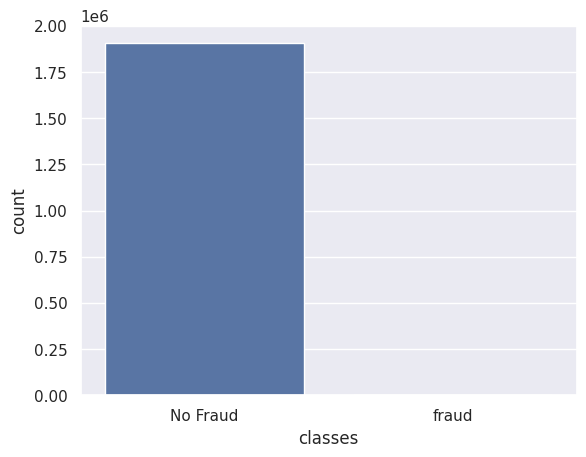

In [ ]:
# Visualise to show level of class imbalance in Paysim Dataset.
import seaborn as sns
import matplotlib.pyplot as plt
label_class= df['IsFraud'].value_counts()
sns.barplot(x=['No Fraud','fraud',],y=label_class, palette="pastel")
plt.title("Class Imbalance in Paysim")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Balance the dataset using Synthetic Minority Oversampling technique.
smt = SMOTE()
# Apply the Synthetic over-sampling technique on the dataset (X and y).
X_resampled, y_resampled = smt.fit_resample(X, y)

In [ ]:
# Balance the dataset using Random Oversampling technique.
# ros = RandomOverSampler()
# Apply the resampling technique on the dataset (X and y).
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# Balance the dataset using Random Undersampling technique.
#rus = RandomUnderSampler(sampling_strategy='auto',
 #     random_state=0,
 #     replacement=True )
# Apply the resampling technique on the dataset (X and y).
#X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
# Balance the dataset using NearMiss technique.
# nm2 = NearMiss(
  #    sampling_strategy='auto',
   #   version=2)
# Apply the resampling technique on the dataset (X and y).
# X_resampled, y_resampled = nm2.fit_resample(X, y)

In [ ]:
# Balance the dataset using Tomek Links.
#tl = TomekLinks(
 #    sampling_strategy='auto',
  #   n_jobs=4)
# Apply the resampling technique on the dataset (X and y).
#X_resampled, y_resampled = tl.fit_resample(X, y)

In [ ]:
# Add a new column named 'target' to the DataFrame `X_resampled`
X_resampled['Class'] = y_resampled

In [ ]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [ ]:
# Initiate spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('empirical-evaluation').getOrCreate()


In [ ]:
# read the CSV file into a Spark DataFrame
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

root
 |-- _c0: integer (nullable = true)
 |-- step: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: integer (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: integer (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- Class: integer (nullable = true)



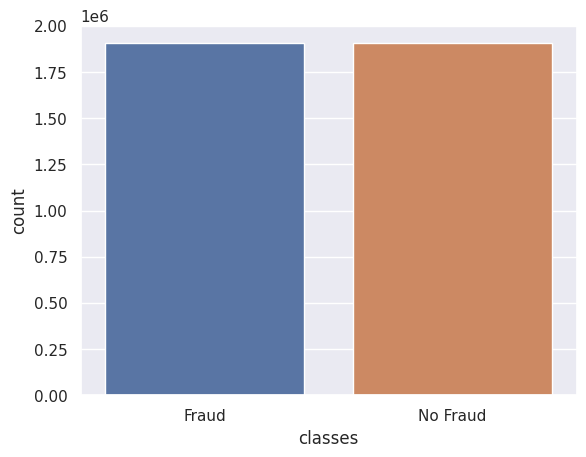

In [ ]:
# Visualise to check the level of class balance
import seaborn as sns
import matplotlib.pyplot as plt
label_class=df.groupBy('Class').count().toPandas()
sns.barplot(x=['Fraud','No Fraud',],y=label_class['count'], palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
df.describe().toPandas()

,summary,_c0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Class
0,count,3812614,3812614,3812614,3812614,3812614,3812614,3812614,3812614,3812614,3812614,3812614,3812614
1,mean,1906306.5,306.5456757489743,2.073043324081588,839807.8073930981,3166694.8198605995,1286071.4822027073,550181.1253408291,518081.63619028835,811409.5156107089,1260405.85135938,2.0274803586200964E-4,0.5
2,stddev,1100607.0039456256,171.791766414199,1.4515155564018831,1903721.1753551823,1835352.730795852,3496507.8402404417,2685892.3058566796,587511.3448377291,2823656.421160007,3318828.506407035,0.01423752022872742,0.500000065571826
3,min,0,1,0,0.0,8,0.0,0.0,1,0.0,0.0,0,0
4,max,3812613,743,4,6.676127221E7,6353304,5.958504037E7,4.958504037E7,2722361,3.2819446492E8,3.555534163E8,1,1


In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- step: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: integer (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: integer (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- Class: integer (nullable = true)



In [ ]:
# Instantiate a 'VectorAssembler` object and transform
sel_cols = df.columns
assembler = VectorAssembler(inputCols = sel_cols, outputCol = "features_vectorize")
data = assembler.transform(df)

In [ ]:
# Select distinct values from the "label" column, order them in ascending order,
# and then collect the values into a list.
label_list = data.select(['Class']).distinct().orderBy('Class').select('Class').rdd.flatMap(lambda x: x).collect()

In [ ]:
# Quick inspection of the data using the first 5 rows
pd.DataFrame(data.take(5),columns=data.columns)

,_c0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Class,features_vectorize
0,0,21,3,16725.81,3723658,817.00,0.00,578707,0.00,0.00,0,0,"(0.0, 21.0, 3.0, 16725.81, 3723658.0, 817.0, 0..."
1,1,379,0,105494.07,1968680,6961427.12,7066921.19,146304,361143.60,255649.53,0,0,"[1.0, 379.0, 0.0, 105494.07, 1968680.0, 696142..."
2,2,20,1,154149.91,4833225,0.00,0.00,559542,167681.07,222500.12,0,0,"[2.0, 20.0, 1.0, 154149.91, 4833225.0, 0.0, 0...."
3,3,279,3,12781.77,2372731,0.00,0.00,1914226,0.00,0.00,0,0,"(3.0, 279.0, 3.0, 12781.77, 2372731.0, 0.0, 0...."
4,4,262,1,55284.27,3510312,763.00,0.00,273684,169957.77,225242.04,0,0,"[4.0, 262.0, 1.0, 55284.27, 3510312.0, 763.0, ..."


In [ ]:
# Split the dataset into training and testing sets
train, test = data.randomSplit([0.8, 0.2], seed = 12)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3049828
Test Dataset Count: 762786


In [ ]:
# Group by 'label' column and count number of occurences
# Convert to a Pandas DataFrame for easier manipulation.
train_label=train.groupBy('Class').count().toPandas()
test_label=test.groupBy('Class').count().toPandas()

In [ ]:
# Initialise Logistic Regression model with specified hyperparameters
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol = 'features_vectorize',
                        labelCol = 'Class', family="multinomial")

# Initialise Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'features_vectorize', labelCol = 'Class')

# Initialise Random Forest model with 20 trees
rf = RandomForestClassifier(labelCol='Class', featuresCol='features_vectorize', numTrees=20)

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes(labelCol='Class', featuresCol='features_vectorize', smoothing=1.0, modelType="multinomial")

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb}

# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]


Models Evaluation:
------------------------


Logistic Regression
now running Logistic Regression model
accuracy = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380974
           1       1.00      1.00      1.00    381812

    accuracy                           1.00    762786
   macro avg       1.00      1.00      1.00    762786
weighted avg       1.00      1.00      1.00    762786

weightedPrecision = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380974
           1       1.00      1.00      1.00    381812

    accuracy                           1.00    762786
   macro avg       1.00      1.00      1.00    762786
weighted avg       1.00      1.00      1.00    762786

weightedRecall = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380974
           1       1.00      1.00      1.00    381812

    accuracy                           1.00    762786
   macr

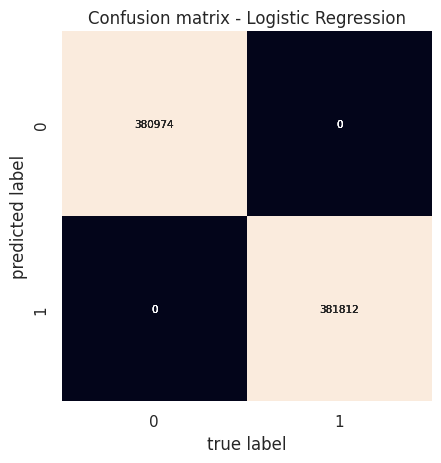

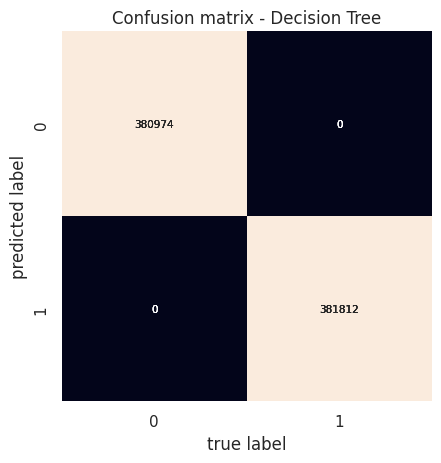

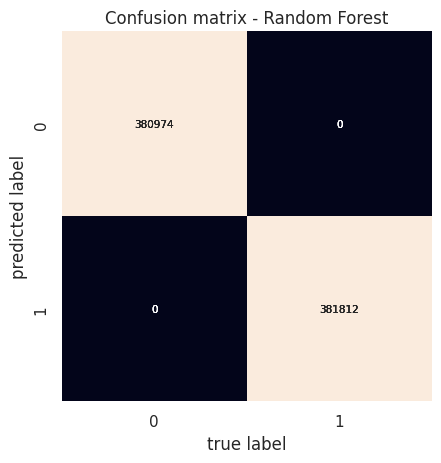

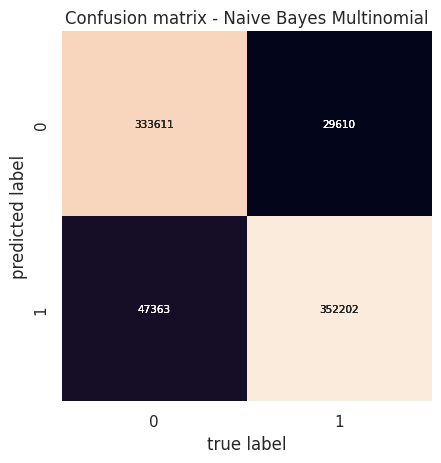

In [ ]:
print("\nModels Evaluation:")
print("{:-<24}".format(""))

# Iterate through each classifier
for idx, c in enumerate(classifiers):
  print(c)
	# Fit the model on the training data
  print(f'now running {c} model')
  model = classifiers[c].fit(train)

  # Use the trained model to make predictions on the test data
  predictions = model.transform(test)
  predictions.cache()

  # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol='Class', predictionCol="prediction")
  for m in metrics:
    evaluator.setMetricName(m)
    metric = evaluator.evaluate(predictions)
    print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn (sktlearn)
    target_list = predictions.select('Class').rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select('Class').distinct().orderBy('Class').rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    print(classification_report(target_list, pred_list))

    # Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                annot_kws={"size": 7.5}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()